Showcase_Notebook

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [107]:
import os
import requests
import pandas as pd
from io import BytesIO
from zipfile import ZipFile
from distance_airports import distance_geo
from plotnine import ggplot, aes, geom_histogram, theme_minimal, scale_fill_manual
import geopandas as gpd
import matplotlib.pyplot as plt


class Airplane:
    """
    A class to download airplane data and perform analysis on it.
    """

    def __init__(self):
        self.airlines_df = pd.DataFrame()
        self.airplanes_df = pd.DataFrame()
        self.airports_df = pd.DataFrame()
        self.routes_df = pd.DataFrame()
        self.merge_df = pd.DataFrame()

    def download_data(self):
        """
        Checks for a 'downloads' folder and creates it if it doesn't exist.
        Downloads flight data from a GitHub repository as a zip file, saves it,
        extracts the contents, and creates Pandas DataFrames from the CSV files:
        - airlines.csv
        - airplanes.csv
        - airports.csv
        - routes.csv
        """
        
        downloads_dir = "downloads"
        if not os.path.exists(downloads_dir):
            os.makedirs(downloads_dir)

        zip_file_path = os.path.join(downloads_dir, "flight_data.zip")

        '''
        Check if the zip file was already downloaded
        '''
        if not os.path.exists(zip_file_path):
            response = requests.get(
                "https://gitlab.com/adpro1/adpro2024/-/"
                "raw/main/Files/flight_data.zip?inline=false",
                stream=True
            )
            '''
            Ensure the request is successful
            '''
            if response.status_code == 200:
                with open(zip_file_path, "wb") as f:
                    f.write(response.content)

        '''
        Extract files if the zip file is downloaded
        '''
        if os.path.exists(zip_file_path):
            with ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(downloads_dir)

                '''
                Loading data into DataFrames
                '''
                self.airlines_df = pd.read_csv(os.path.join(downloads_dir, 'airlines.csv'))
                self.airplanes_df = pd.read_csv(os.path.join(downloads_dir, 'airplanes.csv'))
                self.airports_df = pd.read_csv(os.path.join(downloads_dir, 'airports.csv'))
                self.routes_df = pd.read_csv(os.path.join(downloads_dir, 'routes.csv'))

        '''
        Print the first 5 lines of each dataset
        '''
        print("Airlines DataFrame:\n", self.airlines_df.head())
        print("\nAirplanes DataFrame:\n", self.airplanes_df.head())
        print("\nAirports DataFrame:\n", self.airports_df.head())
        print("\nRoutes DataFrame:\n", self.routes_df.head())

        print("\nDownloaded data executed!")

    def merge_datasets(self) -> pd.DataFrame:
        merge_df_1 = pd.merge(self.routes_df, self.airports_df, left_on="Source airport", right_on="IATA")
        merge_df_1 = merge_df_1.rename(columns={'Country': 'Source country','Latitude':'latitude_source', 'Longitude':'longitude_source'})
    
        merge_df_2 = pd.merge(merge_df_1, self.airports_df[['IATA', 'Country', 'Latitude','Longitude']], left_on='Source airport', right_on='IATA')
        merge_df_2 = merge_df_2.rename(columns={'Country': 'Destination country','Latitude':'latitude_destination', 'Longitude':'longitude_destination' })
    
        merge_df = merge_df_2.dropna(subset=['Source country', 'Destination country'])

        # Assign the resulting merge_df to the instance variable
        self.merge_df = merge_df
    
        return self.merge_df

    def plot_airports_in_country(self, country):
        """
        Plot airports within the chosen country and use the ICAOs as legends.

        Parameters:
        - country (str): The name of the country where airports are to be plotted.
        """
        # Filter airports by the specified country
        country_airports = self.airports_df[self.airports_df['Country'] == country]

        # Exit if no airports are found in the country
        if country_airports.empty:
            print(f"No airports found in {country}.")
            return

        # Load a map of the world
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

        # Filter the map to only include the specified country
        country_map = world[world['name'] == country]

        # Exit if the country is not found in the map dataset
        if country_map.empty:
            print(f"Country '{country}' not found.")
            return

        # Convert the filtered airports data into a GeoDataFrame
        gdf_airports = gpd.GeoDataFrame(
            country_airports,
            geometry=gpd.points_from_xy(country_airports.Longitude, country_airports.Latitude)
        )

        # Plotting
        _, axis = plt.subplots(figsize=(10, 10))
        country_map.plot(ax=axis, color='lightgrey')
        gdf_airports.plot(ax=axis, marker='o', color='red', markersize=5)

        # Annotate each airport with its ICAO code
        for _, row in gdf_airports.iterrows():
            axis.text(row.geometry.x, row.geometry.y, row['ICAO'], fontsize=8)

        plt.title(f"Airports in {country}")
        plt.show()

    
    def distance_analysis(self):
        self.merge_df['distance'] = self.merge_df.apply(
                    lambda row: distance_geo(
                        row['latitude_source'], row['longitude_source'],
                        row['latitude_destination'], row['longitude_destination']
                    ), axis=1
                )
    
        self.merge_df['distance'].head()
    
        distance_plot = (ggplot(self.merge_df, aes(x='distance')) +
                         geom_histogram(bins=30, fill="#5496BF", color="black") +
                         theme_minimal() +
                         scale_fill_manual(values=["#011526", "#C9DFF2", "#5496BF", "#75B2BF", "#025159"]))
        return distance_plot


    def plot_flights_by_code_airports(self, code_airport, n=5, internal=False):
        
        country_of_source = self.merge_df.loc[self.merge_df['Source airport'] == code_airport, 'Source country'].iloc[0]
        
        if internal:
            # Plot only internal flights
            internal_routes = self.merge_df[(self.merge_df["Source airport"] == code_airport) & (self.merge_df["Destination airport"] == code_airport)]
            # Limit to top n destination airports
            internal_routes["Destination airport"].value_counts().head(n).plot(kind="bar", title=f"Top {n} Internal Flights from {code_airport}")
        else:
            # Plot all flights
            all_routes = self.merge_df[self.merge_df["Source airport"] == code_airport]
            # Limit to top n destination airports
            all_routes["Destination airport"].value_counts().head(n).plot(kind="bar", title=f"Top {n} Flights from {code_airport}")
        plt.xlabel("Destination Airport")
        plt.ylabel("Number of Flights")
        plt.show()

    def plot_most_used_airplane_models(self, n: int = 5, countries=None):
        """
        Plot the most used airplane models based on the number of routes.

        Parameters:
            n (int): Number of airplane models to plot, that by default is 5.
            countries: Specific country or list of countries to consider, by default is None.
        """
        if countries is None:
            # Plot most used planes by route using the entire dataset
            top_airplanes = self.merge_df["Equipment"].value_counts().nlargest(n)
        else:
            # Plot most used planes by route for a specific country or list of countries
            if isinstance(countries, str):
                countries = [countries]

            filtered_routes = self.merge_df[self.merge_df["Source country"].isin(countries)]
            top_airplanes = filtered_routes["Equipment"].value_counts().nlargest(n)

        top_airplanes.plot(kind="bar", title=f"Top {n} Airplane Models by Number of Routes")
        plt.xlabel("Airplane Model")
        plt.ylabel("Number of Routes")
        plt.show()

    def plot_flights_by_country(self, country_name, internal=False):
        """
        Plot flights leaving the country with a destination in the same country or all flights.

        Parameters:
            country_name (str): The name of the country.
            internal (bool): If True, plot only internal flights. If False, plot all flights. Default is False.
        """
        if internal is True:
            # Plot only internal flights
            internal_routes = self.merge_df[(self.merge_df["Source country"] == country_name) & (self.merge_df["Destination country"] == country_name)]
            internal_routes["Destination country"].value_counts().plot(kind="bar", title=f"Internal Flights from {country_name}")
        else:
            # Plot all flights
            all_routes = self.merge_df[(self.merge_df["Source country"] == country_name)]
            all_routes["Destination country"].value_counts().plot(kind="bar", title=f"All Flights from {country_name}")

        plt.xlabel("Airplane Model")
        plt.ylabel("Number of Flights")
        plt.show()


Airlines DataFrame:
    index  Airline ID                                          Name Alias IATA  \
0      0          -1                                       Unknown    \N    -   
1      1           1                                Private flight    \N    -   
2      2           2                                   135 Airways    \N  NaN   
3      3           3                                 1Time Airline    \N   1T   
4      4           4  2 Sqn No 1 Elementary Flying Training School    \N  NaN   

  ICAO Callsign         Country Active  
0  NaN       \N              \N      Y  
1  NaN      NaN             NaN      Y  
2  GNL  GENERAL   United States      N  
3  RNX  NEXTIME    South Africa      Y  
4  WYT      NaN  United Kingdom      N  

Airplanes DataFrame:
    index                                          Name IATA code ICAO code
0      0                       Aerospatiale (Nord) 262       ND2      N262
1      1  Aerospatiale (Sud Aviation) Se.210 Caravelle       CRV      S21

C:\Users\Asus\AppData\Local\Temp\ipykernel_9884\586763986.py:112: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.


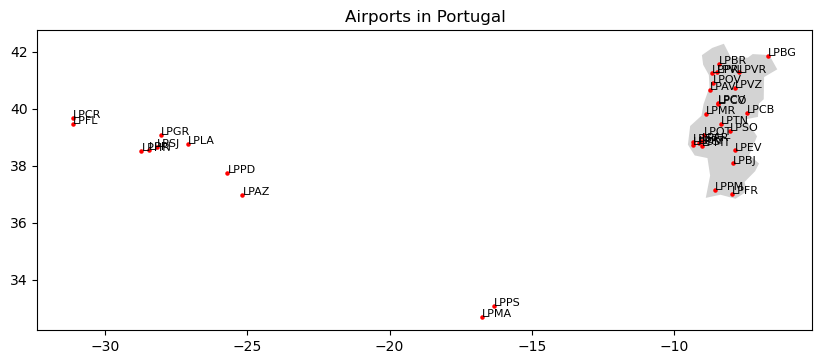

In [108]:
# Test the method 1
airplane_instance = Airplane()

airplane_instance.download_data()

airplane_instance.plot_airports_in_country("Portugal")

This map provides a comprehensive overview of all airports in Portugal, encompassing both mainland and island locations. The airports are visually represented by circles on the map, with their corresponding ICAO codes serving as legends for effortless identification. In case we want to explore airports in a different country we just need to exchange the input.

Airlines DataFrame:
    index  Airline ID                                          Name Alias IATA  \
0      0          -1                                       Unknown    \N    -   
1      1           1                                Private flight    \N    -   
2      2           2                                   135 Airways    \N  NaN   
3      3           3                                 1Time Airline    \N   1T   
4      4           4  2 Sqn No 1 Elementary Flying Training School    \N  NaN   

  ICAO Callsign         Country Active  
0  NaN       \N              \N      Y  
1  NaN      NaN             NaN      Y  
2  GNL  GENERAL   United States      N  
3  RNX  NEXTIME    South Africa      Y  
4  WYT      NaN  United Kingdom      N  

Airplanes DataFrame:
    index                                          Name IATA code ICAO code
0      0                       Aerospatiale (Nord) 262       ND2      N262
1      1  Aerospatiale (Sud Aviation) Se.210 Caravelle       CRV      S21

C:\Users\Asus\anaconda3\Lib\site-packages\plotnine\guides\guides.py:190: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


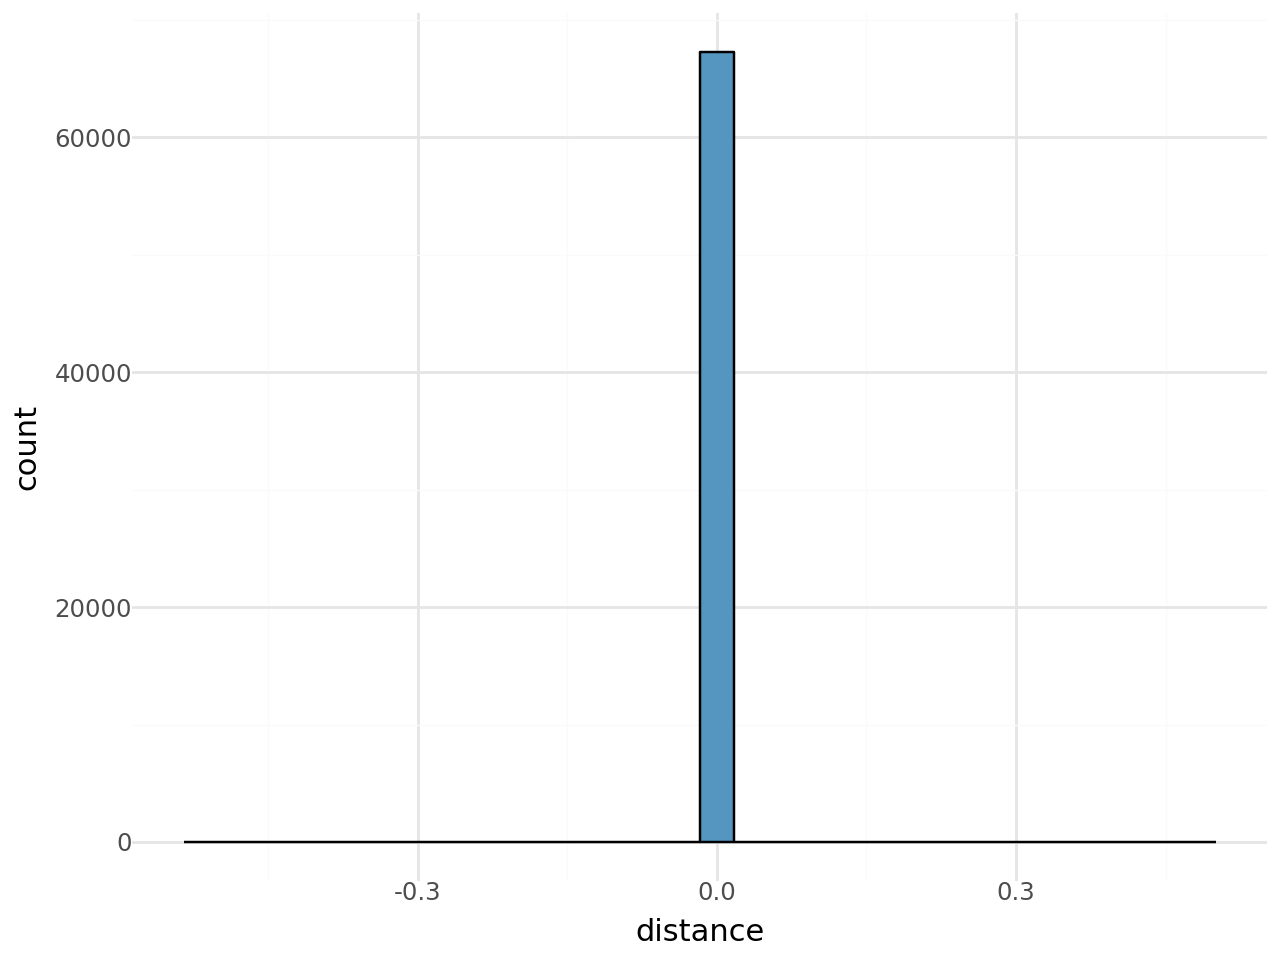

In [103]:
# Test the method 2
airplane_instance = Airplane()


airplane_instance.download_data()


airplane_instance.merge_datasets()


distance_plot = airplane_instance.distance_analysis()


print(airplane_instance.merge_df['distance'].head())


distance_plot.show()

Airlines DataFrame:
    index  Airline ID                                          Name Alias IATA  \
0      0          -1                                       Unknown    \N    -   
1      1           1                                Private flight    \N    -   
2      2           2                                   135 Airways    \N  NaN   
3      3           3                                 1Time Airline    \N   1T   
4      4           4  2 Sqn No 1 Elementary Flying Training School    \N  NaN   

  ICAO Callsign         Country Active  
0  NaN       \N              \N      Y  
1  NaN      NaN             NaN      Y  
2  GNL  GENERAL   United States      N  
3  RNX  NEXTIME    South Africa      Y  
4  WYT      NaN  United Kingdom      N  

Airplanes DataFrame:
    index                                          Name IATA code ICAO code
0      0                       Aerospatiale (Nord) 262       ND2      N262
1      1  Aerospatiale (Sud Aviation) Se.210 Caravelle       CRV      S21

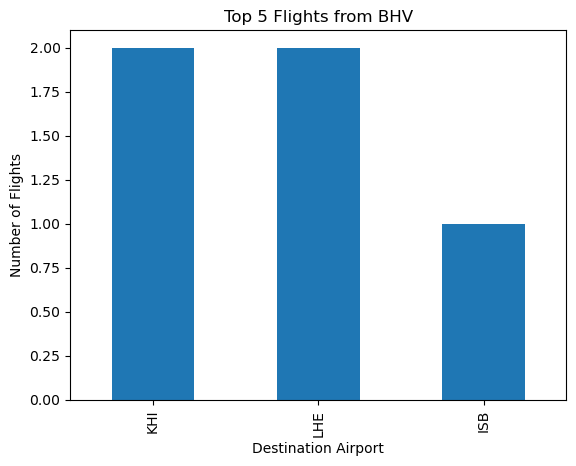

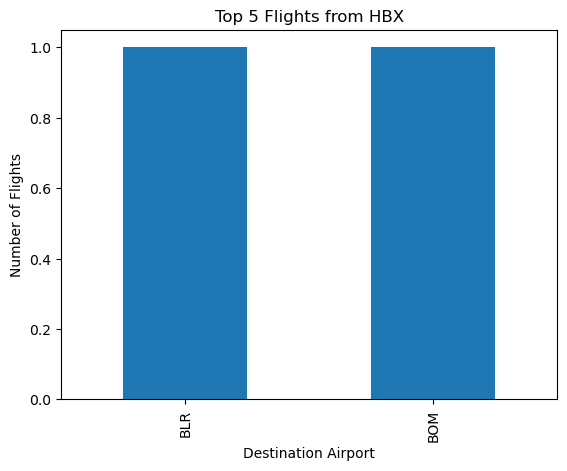

In [64]:
#Test the method 3
# Create an instance of the Airplane class
airplane_instance = Airplane()

# Download and prepare the data
airplane_instance.download_data()

# Assuming the merge_datasets method correctly prepares the 'merge' attribute
airplane_instance.merge = airplane_instance.merge_datasets()

# Test the plot_flights_by_code_airports method
airplane_instance.plot_flights_by_code_airports("BHV", internal=False) #Pakistan
airplane_instance.plot_flights_by_code_airports("HBX", internal=False) #India

From these two histograms we can see that the most used destination airports from the airport BHV thath is in the india are the KHI, LHE and ISB and off this are located in Pakistan. When he do this for the HBX this have the most two flights to the airports BLR and BOM that they are both in India.

Airlines DataFrame:
    index  Airline ID                                          Name Alias IATA  \
0      0          -1                                       Unknown    \N    -   
1      1           1                                Private flight    \N    -   
2      2           2                                   135 Airways    \N  NaN   
3      3           3                                 1Time Airline    \N   1T   
4      4           4  2 Sqn No 1 Elementary Flying Training School    \N  NaN   

  ICAO Callsign         Country Active  
0  NaN       \N              \N      Y  
1  NaN      NaN             NaN      Y  
2  GNL  GENERAL   United States      N  
3  RNX  NEXTIME    South Africa      Y  
4  WYT      NaN  United Kingdom      N  

Airplanes DataFrame:
    index                                          Name IATA code ICAO code
0      0                       Aerospatiale (Nord) 262       ND2      N262
1      1  Aerospatiale (Sud Aviation) Se.210 Caravelle       CRV      S21

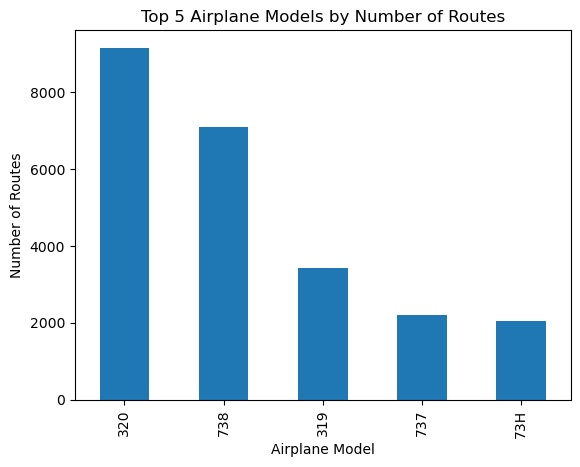

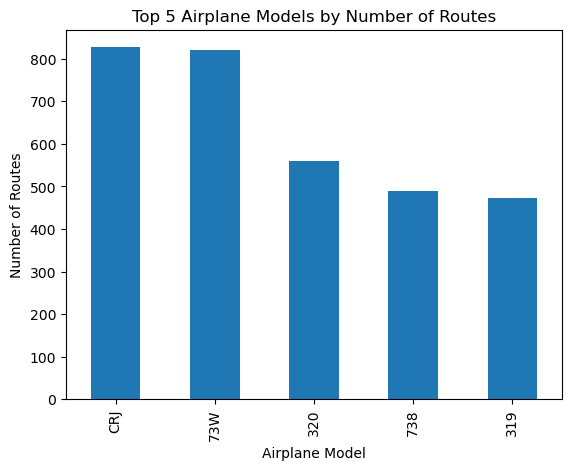

In [65]:
#Test the method 4
# Assuming you have an instance of the RouteAnalyzer class
analyzer_instance = Airplane()

# Download and prepare the data
analyzer_instance.download_data()

# Assuming the merge_datasets method correctly prepares the 'merge' attribute
analyzer_instance.merge = analyzer_instance.merge_datasets()

# Plot for the entire dataset
analyzer_instance.plot_most_used_airplane_models()

# Plot for a specific country or list of countries
analyzer_instance.plot_most_used_airplane_models(countries='United States')

The top 5 models used in the world are the 320, 738,319, 737 and 73H but when we are looking at the top 5 airplanes models in the United State are the CRJ, 73W,320,738 and 319. If we compare only the model 320 is both top 5 model used.

Airlines DataFrame:
    index  Airline ID                                          Name Alias IATA  \
0      0          -1                                       Unknown    \N    -   
1      1           1                                Private flight    \N    -   
2      2           2                                   135 Airways    \N  NaN   
3      3           3                                 1Time Airline    \N   1T   
4      4           4  2 Sqn No 1 Elementary Flying Training School    \N  NaN   

  ICAO Callsign         Country Active  
0  NaN       \N              \N      Y  
1  NaN      NaN             NaN      Y  
2  GNL  GENERAL   United States      N  
3  RNX  NEXTIME    South Africa      Y  
4  WYT      NaN  United Kingdom      N  

Airplanes DataFrame:
    index                                          Name IATA code ICAO code
0      0                       Aerospatiale (Nord) 262       ND2      N262
1      1  Aerospatiale (Sud Aviation) Se.210 Caravelle       CRV      S21

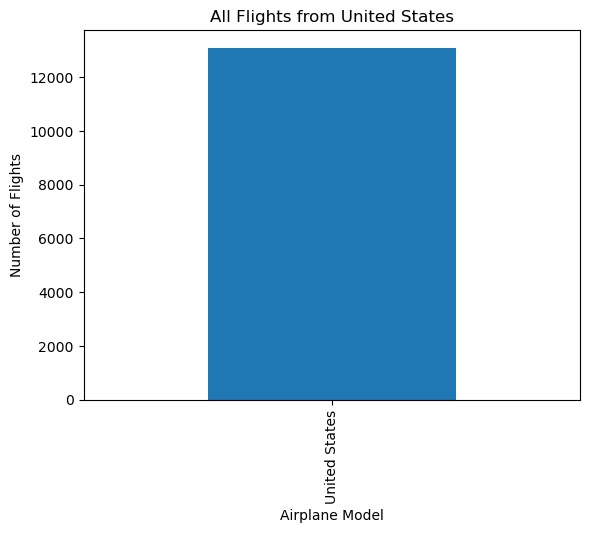

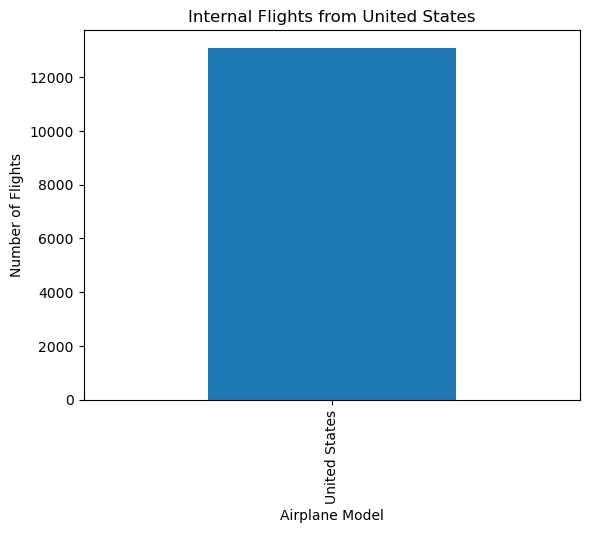

In [109]:
#Test the method 5
# Assuming you have an instance of the RouteAnalyzer class
route_analyzer = Airplane()

# Download and prepare the data
route_analyzer.download_data()

# Assuming the merge_datasets method correctly prepares the 'merge' attribute
route_analyzer.merge = route_analyzer.merge_datasets()

# Call the new method with a specific country (e.g., "United States") and the default internal value (False)
route_analyzer.plot_flights_by_country("United States")

# If you want to specify the internal value, you can do so like this:
route_analyzer.plot_flights_by_country("United States", internal=True)

We can see that United States only has internal flights